Abstract Segmentation with NLP

Research papers often feature abstracts filled with complex academic terminology, which can be time-consuming for readers and researchers to decipher. To expedite the comprehension of experimental or research concepts, it's beneficial for readers to be able to categorize the abstract into four sections: background, methods, results, and conclusions. It is prelevant to encounter papers where these sections are not clearly delineated. We propose harnessing Natural Language Processing (NLP) to automatically segment abstracts into multiple sections in a well-organized structure.

Importing data

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## 1/ Preprocessing data

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
def preprocessing_line(filename):
  sentence_bag = ''
  sentence_file = []
  input_lines = get_lines(filename)
  for sentence in input_lines:
    if sentence.startswith("###"):
      sentence_bag = ''
    elif sentence.isspace():
      sentence_split_space = sentence_bag.splitlines()

      for index, sub_sentence in enumerate(sentence_split_space):
        sentence_sub_bag = {}
        split_sub_sentence = sub_sentence.split("\t")
        sentence_sub_bag['target'] = split_sub_sentence[0] # get the target label
        sentence_sub_bag['text'] = split_sub_sentence[1].lower() # get the target text
        sentence_sub_bag['line_number'] = index # get the number of line
        sentence_sub_bag['total_line'] = len(sentence_split_space) # get the total words per sample
        sentence_file.append(sentence_sub_bag)
    else:
      sentence_bag += sentence
  return sentence_file

In [ ]:
import pandas as pd
train_df = pd.DataFrame(preprocessing_line(data_dir + "train.txt"))
test_df = pd.DataFrame(preprocessing_line(data_dir + "test.txt"))
val_df = pd.DataFrame(preprocessing_line(data_dir + "test.txt"))

In [ ]:
train_df.head(15)

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


#### 1/ Combine all sentences into text

The input to the deep learning model is the string that will be converted to the list

In [ ]:
# Convert the text from abstract into lists
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30135, 30135)

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

#### 2/ ONE HOT ENCODE LABELS

In [ ]:
# Extracting the label by using onehorencoder
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
# How the one hot encoder on the validation set look like
val_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

#### 3/ LABEL ENCODE LABELS

In [ ]:
# Extract the labels and transform it to number by using labelencoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df.target.to_numpy())
val_labels_encoded = label_encoder.transform(val_df.target.to_numpy())
test_labels_encoded = label_encoder.transform(test_df.target.to_numpy())

In [ ]:
# How the label encoder on the train set look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# the number class in the the target set and these tartget instances
num_classes = len(label_encoder.classes_)
classes_name = label_encoder.classes_
num_classes, classes_name

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### 4/The metrics used to evaluate model performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def result_metrics(y_actual, y_pred):
  model_accracy = accuracy_score(y_actual, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_actual, y_pred, average = 'weighted')
  model_result = pd.DataFrame({"accuracy": [model_accracy],
                  "precsion": [model_precision],
                  'recall': [model_recall],
                  'f1': [model_f1]})
  return model_result

## 2/. Deep learning models

### 1/.Model 0: Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ("clf", MultinomialNB())
])
model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X = val_sentences,
              y = val_labels_encoded)

0.716674962667994

In [ ]:
baseline_pred = model_0.predict(val_sentences)
baseline_pred

array([2, 2, 2, ..., 4, 4, 4])

In [ ]:
model_0_df = result_metrics(val_labels_encoded, baseline_pred)
model_0_df.insert(0, "Name_Model", "Baseline")
model_0_df

,Name_Model,accuracy,precsion,recall,f1
0,Baseline,0.716675,0.712432,0.716675,0.69251


It is pivotal to create the dataset by using tf.data, that is enable to load data faster in the GPU  

In [ ]:
import tensorflow as tf
# Turn data to the tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# We turn our data into a prefetchDataset of batches, that can ensure that we can run model as fast as possible
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#### 1 Model_1: Convolution 1D Neural netword  

Methology:
To turn the text into number, we use TextVectorization layer from tensorflow. we still keep all parameters defaults, except the the number of unique words(max_tokens) and the desired output sequence length. Because the average length of the sequence is 55, that cover 95% of the sentence in the dataset.
However, these numbers no longer create the richer relationship with each other, we need to use embedding layer.
The first model, we will build the 1-dimensional convolutional Neural Networdk.


In [ ]:
from tensorflow.keras import layers
max_tokens = 68000
from tensorflow.keras.layers import TextVectorization
import random
# Vectorize text
text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length = 55)
text_vectorizer.adapt(train_sentences)
volcab_in_text = text_vectorizer.get_vocabulary()
# Embedding text
token_embed = layers.Embedding(input_dim = len(volcab_in_text),
                              output_dim = 128,
                               mask_zero = True,
                               name = 'token_embedding')


In [ ]:
# Random sentence applied textvectorization and embedding
random_sentence = random.choice(train_sentences)
sentence_vectorizer = text_vectorizer(random_sentence)
sentence_embed = token_embed(sentence_vectorizer)
sentence_embed

<tf.Tensor: shape=(55, 128), dtype=float32, numpy=
array([[-0.03547736,  0.01975193,  0.01420313, ...,  0.03172999,
        -0.0468987 ,  0.04862008],
       [ 0.00121941, -0.04886654,  0.02600544, ..., -0.02542957,
        -0.01923708, -0.00883678],
       [-0.00227173, -0.03640006, -0.02341785, ...,  0.02176431,
         0.03267061,  0.01908841],
       ...,
       [ 0.02987647,  0.02947002,  0.04605658, ..., -0.02176753,
         0.0285028 ,  0.03061703],
       [ 0.02987647,  0.02947002,  0.04605658, ..., -0.02176753,
         0.0285028 ,  0.03061703],
       [ 0.02987647,  0.02947002,  0.04605658, ..., -0.02176753,
         0.0285028 ,  0.03061703]], dtype=float32)>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype = tf.string)
token_embedding = text_vectorizer(inputs)
token_embeddings = token_embed(token_embedding)
x = layers.Conv1D(64, kernel_size = 5, padding = "same", activation = 'relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation = 'softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

the workflow of the model 1 


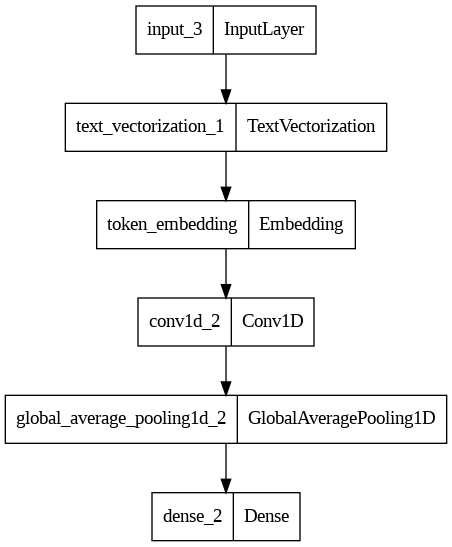

In [ ]:
from tensorflow.keras.utils import plot_model
print(f"the workflow of the model 1 ")
plot_model(model_1)

In [ ]:
model_1.summary()

Model: "model_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_17 (Tex  (None, 55)                0         
 tVectorization)                                                 
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_13 (Conv1D)          (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
 0 (GlobalAveragePooling1D)                                      
                                                         

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 17s 29ms/step - loss: 0.9260 - accuracy: 0.6273 - val_loss: 0.6897 - val_accuracy: 0.7281
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6588 - accuracy: 0.7539 - val_loss: 0.6400 - val_accuracy: 0.7666
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6191 - accuracy: 0.7735 - val_loss: 0.5912 - val_accuracy: 0.7812


In [ ]:
model_1.evaluate(val_dataset)

942/942 [==============================] - 3s 3ms/step - loss: 0.6124 - accuracy: 0.7820


[0.6124178171157837, 0.7819811105728149]

In [ ]:
model_1_pred = model_1.predict(val_dataset)
model_1_pred = tf.argmax(model_1_pred, axis = 1)
model_1_pred

942/942 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 4])>

In [ ]:
model_1_df = result_metrics(val_labels_encoded, model_1_pred)
model_1_df.insert(0, "Name_Model", "Model_1")
model_1_df

,Name_Model,accuracy,precsion,recall,f1
0,Model_1,0.781981,0.779739,0.781981,0.779988


#### 2.Model_2: Fitting NLP feature extraction by Pretrained token embedding

We use the feature extraction transfer learning from the Neural Networks for Joint Sentence Classification in Medical Paper Abstracts, that is the way to begin token embedding. However, we just want to use the embedding layer without utilising other layers,  setting trainable is false. Then we was applying the token in the embedding layer and adding our own layers to train model.

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable = False,
                                  name = "universial_model")

In [ ]:
# Example of applying pretrained embedding on the random sentence
random_sentence = random.choice(train_sentences)
print(f"Random sentence before embedding is\n {random_sentence}")

embedding_sentence = tf_hub_embedding([random_sentence])
print(f"Sentence after embedding {embedding_sentence}")

print(f"The length of embedding: {len(embedding_sentence[0])}")

Random sentence before embedding is
 compared with udc , more ic patients reached hba@c targets of < @ % ( @ mmol/mol ; @ vs. @ % , respectively , p < @ ) and < @ % ( @ mmol/mol ; @ vs. @ % , respectively , p < @ ) .
Sentence after embedding [[-0.00632177 -0.07279091  0.02539157  0.00123483  0.03415223 -0.06879918
  -0.03139625 -0.03338647 -0.06498446 -0.00607484  0.07540822 -0.03429439
  -0.01035777 -0.00128238  0.05961156 -0.05234265 -0.07533561  0.03200801
   0.02593959 -0.02843563  0.07946219 -0.03264504 -0.01540184 -0.05448438
   0.03362187  0.01696674  0.04203029  0.06237685 -0.00094357 -0.05517263
  -0.00279734  0.07884647 -0.0336932  -0.04239246 -0.02743429  0.00690467
   0.03214564 -0.04525828 -0.02349353 -0.05923894  0.02492402  0.04095187
  -0.03282467  0.0401699   0.05130333  0.06773803 -0.00495673  0.04153712
  -0.05070046 -0.01017917 -0.01952052 -0.00198268 -0.07323223 -0.07821302
   0.03277018 -0.028751   -0.07537936  0.0519783  -0.0617623  -0.01314403
  -0.01023405  0.0

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
import tensorflow_hub as hub

# Define input layer
input_layer = Input(shape=(), dtype=tf.string)

# Define the model
model_2 = tf.keras.Sequential([
    input_layer,
    tf_hub_embedding,
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

The workflow of the model 2


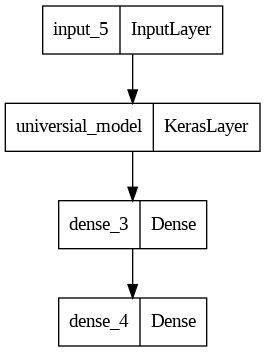

In [ ]:
print("The workflow of the model 2")
plot_model(model_2)

In [ ]:
model_2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 universial_model (KerasLay  (None, 512)               256797824 
 er)                                                             
                                                                 
 dense_129 (Dense)           (None, 128)               65664     
                                                                 
 dense_130 (Dense)           (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch = int(0.1*len(train_dataset)),
            epochs = 4,
            validation_data = val_dataset,
            validation_steps= int(0.1*len(val_dataset)))

Epoch 1/4
562/562 [==============================] - 9s 11ms/step - loss: 0.9182 - accuracy: 0.6501 - val_loss: 0.8306 - val_accuracy: 0.6822
Epoch 2/4
562/562 [==============================] - 6s 10ms/step - loss: 0.7683 - accuracy: 0.7010 - val_loss: 0.7793 - val_accuracy: 0.6961
Epoch 3/4
562/562 [==============================] - 6s 10ms/step - loss: 0.7519 - accuracy: 0.7119 - val_loss: 0.7548 - val_accuracy: 0.7064
Epoch 4/4
562/562 [==============================] - 6s 10ms/step - loss: 0.7182 - accuracy: 0.7240 - val_loss: 0.7290 - val_accuracy: 0.7214


In [ ]:
model_2.evaluate(val_dataset)

942/942 [==============================] - 8s 8ms/step - loss: 0.7299 - accuracy: 0.7217


[0.7298502326011658, 0.7216857671737671]

In [ ]:
model_2_pred = model_2.predict(val_dataset)
model_2_pred = tf.argmax(model_2_pred, axis = 1)
model_2_pred

942/942 [==============================] - 8s 8ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 0, 2, ..., 4, 4, 1])>

In [ ]:
model_2_df= result_metrics(val_labels_encoded, model_2_pred)
model_2_df.insert(0, "Name_Model", "Model_2")
model_2_df

,Name_Model,accuracy,precsion,recall,f1
0,Model_2,0.721686,0.71674,0.721686,0.716257


#### 3.Model_3: Con1D with character embedding


we've built models with a character-level embedding by first vectorizing our sequences using the textvectorization class and pass those vectorized sequence through an embedding layer. The different between the token level embedding and charecter level embedding is that the token level embeddding will seperatre the sequences into tokens (words) and embedding each of them, character embedding split sequences into letters and apply the vectororization for each letter.

In [ ]:
def split_char(text):
  return " ".join(list(text))

Split the sequence into the individual letter

In [ ]:
train_char = [split_char(sentence) for sentence in train_sentences]
test_char = [split_char(sentence) for sentence in test_sentences]
val_char = [split_char(sentence) for sentence in val_sentences]

Calculate the average length of sentence

In [ ]:
import numpy as np
len_sentence = [len(sentence) for sentence in train_sentences]
avg_len_sentence = np.mean(len_sentence)
avg_len_sentence

149.3662574983337

In [ ]:
output_len_sentence = int(np.percentile(len_sentence, 95))
output_len_sentence

290

In [ ]:
# Get all character for character embedding

import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Generate a vector representation for sentences by incorporating both the average sentence length and the maximum number of tokens. This vector should encapsulate the likelihood of each token occurring in the sentences. To achieve this, tokenize the sentences, calculate the average sentence length, determine the token likelihood, and create vectors for each sentence. Ensure that the vectors are adjusted to the average length, and consider the maximum tokens for completeness. This approach aims to capture the essence of token through a comprehensive vectorization process.






In [ ]:
character_vectorizer = TextVectorization(max_tokens = len(alphabet) + 2,
                                        output_sequence_length = output_len_sentence,
                                        standardize = 'lower_and_strip_punctuation',
                                        name = 'char_vectorizer')

character_vectorizer.adapt(train_char)

In [ ]:
cha_vocab = character_vectorizer.get_vocabulary()

print(f"The different character in the vocabulary {len(cha_vocab)}")
print(f"The most common character in the vocabulary {cha_vocab[:5]}")
print(f"The least common character in the vocabulary {cha_vocab[-5:]}")

The different character in the vocabulary 28
The most common character in the vocabulary ['', '[UNK]', 'e', 't', 'i']
The least common character in the vocabulary ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_char = random.choice(train_char)

print(f"The character before doing textvectorization {random_char}")
print(f"\nThe lengh of random_char: {len(random_char.split())}")
random_char_vector = character_vectorizer(random_char)
print(f"\nThe tokens of random characters after doing textvectorization {random_char_vector}")
print(f"\nThe length of the vectorized token: {len(random_char_vector)}")

The character before doing textvectorization t h e   i n v e s t i g a t o r   a s   w e l l   a s   t h e   p a r t i c i p a n t s   w a s   b l i n d e d   t o   t h e   s t i m u l a t i o n   m o d a l i t y   .

The lengh of random_char: 73

The tokens of random characters after doing textvectorization [ 3 13  2  4  6 21  2  9  3  4 18  5  3  7  8  5  9 20  2 12 12  5  9  3
 13  2 14  5  8  3  4 11  4 14  5  6  3  9 20  5  9 22 12  4  6 10  2 10
  3  7  3 13  2  9  3  4 15 16 12  5  3  4  7  6 15  7 10  5 12  4  3 19
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0

In [ ]:
embedding_char = layers.Embedding(input_dim = len(alphabet) + 2,
                                  output_dim = 25,
                                  mask_zero = False,
                                  name = "emdding_char")

print(f"The sentence before doing embedding {random_char}")
print(f"The sentence after doing embedding: {embedding_char(character_vectorizer(random_char))}")
print(f"The shape of sentence after doing embedding {embedding_char(character_vectorizer(random_char)).shape}")

The sentence before doing embedding t h e   i n v e s t i g a t o r   a s   w e l l   a s   t h e   p a r t i c i p a n t s   w a s   b l i n d e d   t o   t h e   s t i m u l a t i o n   m o d a l i t y   .
The sentence after doing embedding: [[ 0.04095009  0.01682599  0.00456679 ...  0.04475734 -0.04881465
  -0.04720157]
 [ 0.0271364   0.03855855 -0.02709887 ... -0.04839684 -0.04321203
  -0.03630609]
 [ 0.03542869  0.03648326  0.04465586 ... -0.00757333 -0.04300729
  -0.03132899]
 ...
 [ 0.01146061  0.00480022 -0.02353787 ...  0.02644226  0.02928121
   0.04079255]
 [ 0.01146061  0.00480022 -0.02353787 ...  0.02644226  0.02928121
   0.04079255]
 [ 0.01146061  0.00480022 -0.02353787 ...  0.02644226  0.02928121
   0.04079255]]
The shape of sentence after doing embedding (290, 25)


In [ ]:
train_char_prefetch = tf.data.Dataset.from_tensor_slices((train_char, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_prefetch = tf.data.Dataset.from_tensor_slices((test_char, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_predetch = tf.data.Dataset.from_tensor_slices((val_char, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_prefetch

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Sequential

# Define your preprocessing layers
# Assuming you have defined character_vectorizer and embedding_char appropriately

# Example:
# character_vectorizer = SomeCharacterVectorizerLayer(...)
# embedding_char = SomeEmbeddingLayer(...)

# Assuming num_classes is defined

model_3 = Sequential([
    Input(shape=(1,), dtype='string'),
    character_vectorizer,
    embedding_char,
    Conv1D(64, kernel_size=5, padding="same", activation='relu'),
    GlobalMaxPooling1D(),
    Dense(num_classes, activation='softmax')
])

model_3.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [ ]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 emdding_char (Embedding)    (None, 290, 25)           1750      
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_67 (Dense)            (None, 5)                 325       
                                                                 
Total params: 10139 (39.61 KB)
Trainable params: 10139

In [ ]:
model_3_history = model_3.fit(train_char_prefetch,
                              steps_per_epoch = int(0.1*len(train_char_prefetch)),
                              epochs = 5,
                              validation_data = test_char_prefetch,
                              validation_steps = int(0.1*len(test_char_prefetch)))

Epoch 1/5
562/562 [==============================] - 4s 5ms/step - loss: 1.2670 - accuracy: 0.4743 - val_loss: 1.0626 - val_accuracy: 0.5854
Epoch 2/5
562/562 [==============================] - 3s 5ms/step - loss: 1.0229 - accuracy: 0.5879 - val_loss: 0.9656 - val_accuracy: 0.6187
Epoch 3/5
562/562 [==============================] - 3s 5ms/step - loss: 0.9309 - accuracy: 0.6375 - val_loss: 0.8759 - val_accuracy: 0.6562
Epoch 4/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8727 - accuracy: 0.6580 - val_loss: 0.8312 - val_accuracy: 0.6749
Epoch 5/5
562/562 [==============================] - 3s 5ms/step - loss: 0.8572 - accuracy: 0.6674 - val_loss: 0.8148 - val_accuracy: 0.6902


In [ ]:
model_3.evaluate(val_char_predetch)

942/942 [==============================] - 3s 3ms/step - loss: 0.8403 - accuracy: 0.6731


[0.8402944803237915, 0.6731375455856323]

In [ ]:
model_3_pred = model_3.predict(val_char_predetch)
model_3_pred = tf.argmax(model_3_pred, axis = 1)

model_3_pred

942/942 [==============================] - 2s 2ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([1, 2, 2, ..., 4, 4, 2])>

In [ ]:

model_3_df = result_metrics(val_labels_encoded, model_3_pred)
model_3_df.insert(0, "Name_Model", "Model_3")
model_3_df

,Name_Model,accuracy,precsion,recall,f1
0,Model_3,0.673138,0.677244,0.673138,0.667777


###4. Model_4 Hydrid model combines the pretrained model and character-level sequences

We built the hybrid token embedding layer that is the combination of token embedding and character embedding. In other words, we built the stacked embedding to the represent sequence before passing them to the sequence label prediction layer. The first embedding that would get from the model 2 and another character embeddeing that borrow from the model 3. Building the model which takes the token, character- level sequences as the input and come through output layer to produce the label probability

In [ ]:
# pretrained model
token_inputs = layers.Input(shape = [], dtype = tf.string, name = "token_input ")
token_embedding = tf_hub_embedding(token_inputs)
token_output = layers.Dense(128, activation = 'relu')(token_embedding)
layer_1 = tf.keras.Model(inputs = token_inputs, outputs= token_output)

In [ ]:
# character-level sequences

char_inputs = layers.Input(shape = (1,), dtype = tf.string, name = "char_input")
char_vector = character_vectorizer(char_inputs)
char_embed = embedding_char(char_vector)
char_LSTM = layers.Bidirectional(layers.LSTM(25))(char_embed)
layer_2 = tf.keras.Model(inputs = char_inputs,
                             outputs = char_LSTM)


In [ ]:
token_combine = layers.Concatenate(name = 'token_char_combine')([layer_1.output,
                                                                 layer_2.output])

token_dropout_1 = layers.Dropout(0.5)(token_combine)
token_dense_1 = layers.Dense(200, activation = 'relu')(token_dropout_1)
token_dropout_2 = layers.Dropout(0.5)(token_dense_1)
token_dense_2 = layers.Dense(5, activation = 'softmax')(token_dropout_2)

model_4= tf.keras.Model(inputs = [layer_1.input,layer_2.input],
                        outputs = token_dense_2,
                        name = "model_4_combined_token_and_char")

Model: "model_4_combined_token_and_char"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input  (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universial_model (KerasLay  (None, 512)                  2567978   

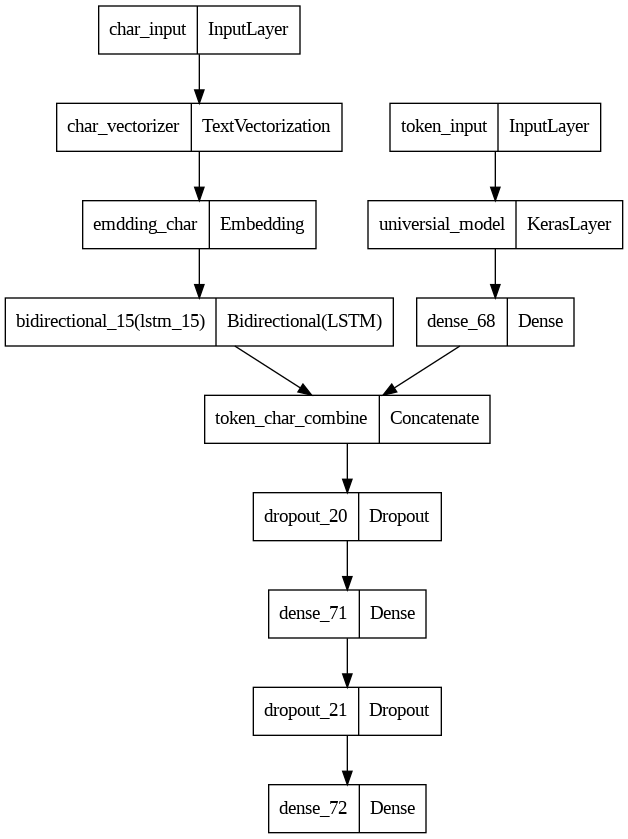

In [ ]:
from tensorflow.keras.utils import plot_model

model_4.summary()

plot_model(model_4)

In [ ]:
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [ ]:
# Combine char and token into the same dataset

train_char_token = tf.data.Dataset.from_tensor_slices((train_sentences, train_char))
train_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_label = tf.data.Dataset.zip((train_char_token,train_label))

In [ ]:
train_data_prefetch = train_char_token_label.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token = tf.data.Dataset.from_tensor_slices((val_sentences, val_char))
val_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_label = tf.data.Dataset.zip((val_char_token,val_label))
val_data_prefetch = val_char_token_label.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
model_4_history = model_4.fit(train_data_prefetch,
                              steps_per_epoch= int(0.1*(len(train_data_prefetch))),
                              epochs = 5,
                              validation_data = val_data_prefetch,
                              validation_steps = int(0.1*(len(val_data_prefetch))))

Epoch 1/5
562/562 [==============================] - 18s 24ms/step - loss: 0.9738 - accuracy: 0.6176 - val_loss: 0.8069 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7909 - accuracy: 0.6972 - val_loss: 0.7338 - val_accuracy: 0.7234
Epoch 3/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7667 - accuracy: 0.7096 - val_loss: 0.7081 - val_accuracy: 0.7271
Epoch 4/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7379 - accuracy: 0.7230 - val_loss: 0.6871 - val_accuracy: 0.7407
Epoch 5/5
562/562 [==============================] - 12s 22ms/step - loss: 0.7413 - accuracy: 0.7143 - val_loss: 0.6771 - val_accuracy: 0.7380


In [ ]:
model_4.evaluate(val_data_prefetch)

942/942 [==============================] - 10s 11ms/step - loss: 0.6783 - accuracy: 0.7389


[0.6782939434051514, 0.7389082312583923]

In [ ]:
model_4_pred = model_4.predict(val_data_prefetch)
model_4_pred = tf.argmax(model_4_pred, axis = 1 )
model_4_pred

942/942 [==============================] - 11s 10ms/step


<tf.Tensor: shape=(30135,), dtype=int64, numpy=array([0, 2, 2, ..., 4, 4, 2])>

In [ ]:
model_4_df = result_metrics(val_labels_encoded, model_4_pred)
model_4_df.insert(0, "Name_Model", "Model_4")
model_4_df

,Name_Model,accuracy,precsion,recall,f1
0,Model_4,0.738908,0.735668,0.738908,0.732893


#### Model 5: Transfer Learning with pretrained token embedding, character embedding, transitional embedding

The fourth model appears to show better potential for improvement compared to the previous ones. In this iteration, we aim to enhance the model's performance by incorporating additional features. Given that the taglines in each segment follow a specific order and the length of each part contributes to its uniqueness, Model 5 will be updated by including two additional features: line number and total lines, as part of the input.






Tranfer the line number into one hot

<Axes: >

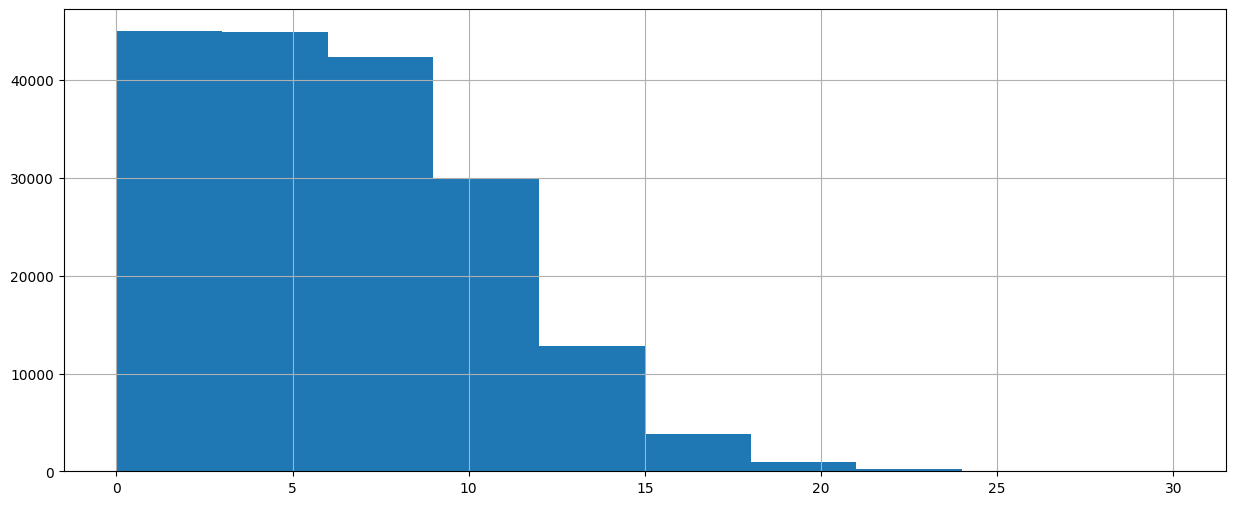

In [ ]:
train_df['line_number'].hist(figsize = (15,6))

The plot show the primary line number is equal to or less than 15

In [ ]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)

In [ ]:
print(f"The shape of the train line number one hot: {train_line_number_one_hot.shape}")
print(f"The train line number one hot: {train_line_number_one_hot[:20]}")

The shape of the train line number one hot: (180040, 15)
The train line number one hot: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Transfer total line number of an article into one hot

<Axes: ylabel='Frequency'>

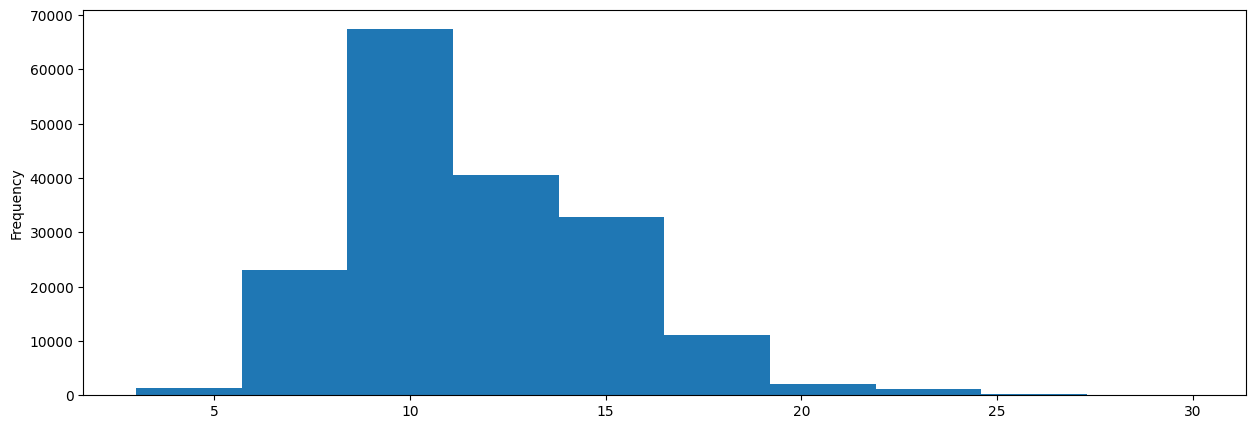

In [ ]:
train_df['total_lines'].plot.hist(figsize = (15,5))

In [ ]:
np.percentile(train_df['total_lines'], 98)

21.0

In [ ]:
train_total_line_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
test_total_line_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
val_total_line_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)

In [ ]:
print(f"The shape of one hot encoded total line in train dataset: {train_total_line_one_hot.shape} ")
print(f"The one hot encoded total line in train dataset: {train_total_line_one_hot[:20]}")

The shape of one hot encoded total line in train dataset: (180040, 20) 
The one hot encoded total line in train dataset: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
# 1./ token inputs
token_inputs = layers.Input(shape = [], dtype = 'string', name = 'token inputs')
token_embedding = tf_hub_embedding(token_inputs)
token_output = layers.Dense(128, activation = "relu")(token_embedding)
token_model = tf.keras.Model(inputs = token_inputs, outputs = token_output)

# 2./ character inputs
char_inputs = layers.Input(shape= (1,), dtype = 'string', name = 'char inputs')
char_vector = character_vectorizer(char_inputs)
char_embed = embedding_char(char_vector)
char_LSTM = layers.Bidirectional(layers.LSTM(32))(char_embed)
character_model = tf.keras.Model(inputs = char_inputs,
                             outputs = char_LSTM)

#3./ total line inputs
total_lines_input = layers.Input(shape = (20,), dtype = tf.int32, name = "total_line_inputs")
total_line_dense = layers.Dense(32, activation = 'relu')(total_lines_input)
total_line_model = tf.keras.Model(inputs = total_lines_input,
                                  outputs = total_line_dense)

#4./ line number inputs
line_number_inputs = layers.Input(shape = (15,), dtype = tf.int32, name = 'line_number_inputs')
line_number_dense = layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_dense)

#5./ Combining token inputs and character inputs
combining_layer = layers.Concatenate(name = 'token_character')([token_model.output,
                                                                character_model.output])
combining_dense = layers.Dense(256, activation = "relu")(combining_layer)
combining_dropout = layers.Dropout(0.5)(combining_dense)

# 6./ Combining token-character layers with total line model and line number model
combining_layer_2 = layers.Concatenate(name = 'combining_layer')([total_line_model.output,
                                                                  line_number_model.output,
                                                                  combining_dropout])

combining_dense_f = layers.Dense(5, activation = 'softmax', name = 'final_layer')(combining_layer_2)
model_5 = tf.keras.Model(inputs = [token_model.input,
                                   character_model.input,
                                   total_line_model.input,
                                   line_number_model.input],
                         outputs = combining_dense_f )

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_109"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universial_model (KerasLay  (None, 512)                  2567978   ['token inputs[0][0]']

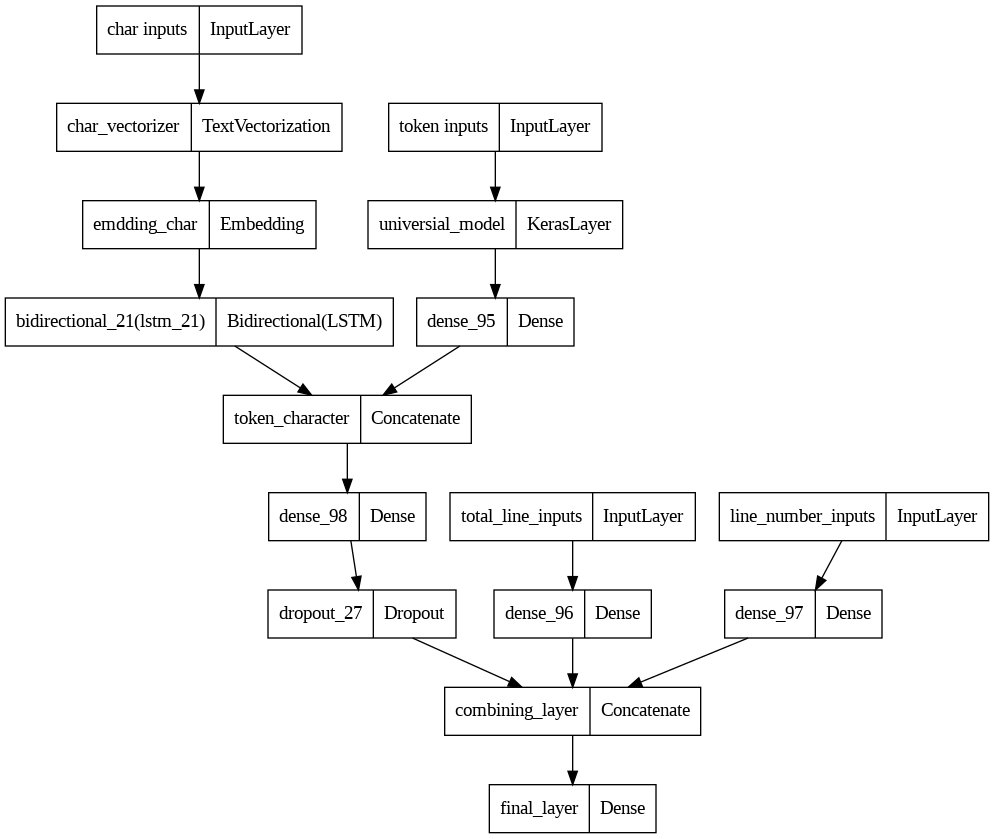

In [ ]:
plot_model(model_5)

In [ ]:
train_model_5_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                         train_total_line_one_hot,
                                                         train_sentences,
                                                         train_char))

train_model_5_label = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_model_5_dataset = tf.data.Dataset.zip((train_model_5_data, train_model_5_label))

train_model_5_dataset = train_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
len(val_line_number_one_hot), len(val_total_line_one_hot), len(val_sentences), len(val_char)

(30135, 30135, 30135, 30135)

In [ ]:
val_model_5_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                         val_total_line_one_hot,
                                                         val_sentences,
                                                         val_char))

val_model_5_label = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_model_5_dataset = tf.data.Dataset.zip((val_model_5_data, val_model_5_label))

val_model_5_dataset = val_model_5_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_model_5 = model_5.fit(train_model_5_dataset,
                              steps_per_epoch=int(0.1 * len(train_model_5_dataset)),
                              epochs=3,
                              validation_data=val_model_5_dataset,
                              validation_steps=int(0.1 * len(val_model_5_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 24ms/step - loss: 0.9448 - accuracy: 0.8306 - val_loss: 0.9317 - val_accuracy: 0.8341
Epoch 2/3
562/562 [==============================] - 13s 23ms/step - loss: 0.9254 - accuracy: 0.8448 - val_loss: 0.9251 - val_accuracy: 0.8411
Epoch 3/3
562/562 [==============================] - 13s 23ms/step - loss: 0.9230 - accuracy: 0.8425 - val_loss: 0.9245 - val_accuracy: 0.8378


In [ ]:
model_5_pred = model_5.predict(val_pos_char_token_dataset, verbose = 1)
model_5_pred

945/945 [==============================] - 12s 12ms/step


array([[0.51060873, 0.1021139 , 0.01357946, 0.35677668, 0.01692115],
       [0.5573089 , 0.10143069, 0.05582482, 0.2752545 , 0.01018108],
       [0.31521985, 0.09963059, 0.11144072, 0.4094913 , 0.06421757],
       ...,
       [0.03787327, 0.10745428, 0.04010564, 0.03351078, 0.7810561 ],
       [0.0285746 , 0.3630924 , 0.05377201, 0.02586759, 0.5286934 ],
       [0.19173639, 0.6878314 , 0.05187658, 0.03794219, 0.03061343]],
      dtype=float32)

In [ ]:
model_5_prediction = tf.argmax(model_5_pred, axis = 1)
model_5_prediction

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_df = result_metrics(val_labels_encoded, model_5_prediction)
model_5_df.insert(0, "Name_Model", "Model_5")
model_5_df

,Name_Model,accuracy,precsion,recall,f1
0,Model_5,0.842513,0.841781,0.842513,0.841394


In [ ]:
df_result = pd.concat([model_0_df,model_1_df, model_2_df, model_3_df, model_4_df, model_5_df], axis = 0)
df_result

,Name_Model,accuracy,precsion,recall,f1
0,Baseline,0.716675,0.712432,0.716675,0.692510
0,Model_1,0.781981,0.779739,0.781981,0.779988
0,Model_2,0.721686,0.716740,0.721686,0.716257
0,Model_3,0.673138,0.677244,0.673138,0.667777
0,Model_4,0.738908,0.735668,0.738908,0.732893
0,Model_5,0.842513,0.841781,0.842513,0.841394


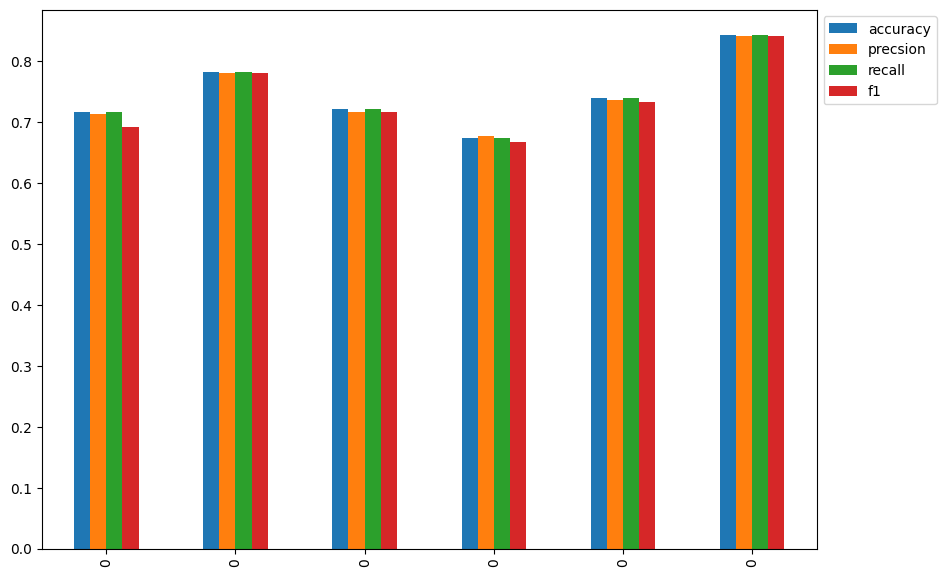

In [ ]:
df_result.plot(kind = 'bar', figsize = (10,7)).legend(bbox_to_anchor = (1.0, 1.0))


<Axes: xlabel='Name_Model', ylabel='f1'>

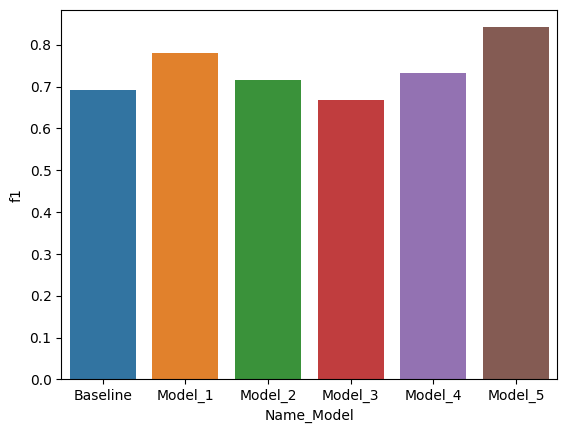

In [ ]:
sns.barplot(x = "Name_Model", y = 'f1', data = df_result)

The model 5 is seemly the best model with high accuracy so far. However, we just trained only 20.000 sentences out of 180000 sequences in the the dataset. We need to expand the project in some ways like hypertunner parameters, test the performance on the testset.